# Python de tractament d'experiments

Experiments fets al 2017

In [1]:
from fluids import *
from thermo import Mixture
from scipy.constants import atmosphere, zero_Celsius, mmHg, g
import scipy as sci
import uncertainties
from uncertainties.unumpy import *
from uncertainties import *
from numpy import *
import numpy  as np
import matplotlib.pyplot as plt
import pwlf

from pandas import *
import pandas as pd

In [2]:
def area(x):
    return np.pi*x**2/4
def perimetre(x):
    return np.pi*x

def chocked_mass_flow (pressure, temp,  area):
        gamma = 1.4
        if temp-zero_Celsius < 0:
            print("has de sumar-hi el conversor de k a ºC")
        else:    
            air = Mixture( 'air' , T = temp , P = pressure )
            r   = sci.constants.R / air.MW * 1000
   
            d   = gamma+1
            e   = 2*(gamma-1)
    
            A   = pressure * area
            B   = (r*temp) **(-0.5)
            C   = (gamma ) **0.5
            D   = (  2 / d  )**(d/e)
            
        return  A * B * C * D

def f_mdot_s ( mesures1 , mesures2 , petitOgran, waterOalco ):
    
    taps        = 'flange'
    meter_type  = 'long radius nozzle'
    
    air   = Mixture('air',T=T_amb,P=P_amb)
    k     = air.isentropic_exponent
    mu    = air.mu
    rho   = air.rho
    
    if petitOgran == 1:   
        Do     = ufloat(10.3e-3,DeltaMM)         # orifice diameter in m (large nozzle)
        D      = ufloat(30e-3,DeltaM)
    else:
        Do     = ufloat(5.15e-3, DeltaMM)         # orifice diameter in m (small nozzle)
        D      = ufloat(25e-3,DeltaM)
        
    if waterOalco == 1:
        manRelRho = 1000
    else: 
        manRelRho = 791.8
    
    
    h1  = uarray(mesures1 ,DeltaH*ones(len (mesures1)))
    h2  = uarray(mesures2 ,DeltaH*ones(len (mesures2)))

    p1   = (h2 * g * manRelRho)/1000 # p1 is the bigger pressure, and 
    p2   = (h1 * g * manRelRho)/1000 # p2 is the low pressure in the nozzle
    DeltaP = p1 - p2
    
    mdot = uarray( zeros(len (mesures1)) , zeros(len (mesures1)) )
    mdot_t = uarray( zeros(len (mesures1)) , zeros(len (mesures1)) )

    for i in range( len(mesures1) ):
        
        if nominal_value(DeltaP[i]) != 0.0:        # Just to avoid division by 0 when DeltaP=0. .
            mdot[i] = wrappedFlowMeter(D=D, D2=Do, P1=P_amb , P2=P_amb-DeltaP[i] , rho=rho, mu=mu, k=k, meter_type=meter_type, taps=taps)  
        else:
            mdot[i] = ufloat(0.0,0.0)
    mdot_n = mdot*60000/rhoN
    
    return mdot, mdot_n
        
def f_mdot_p ( mesures1 , mesures2 , mesuresT  ):

    taps       = 'flange'
    meter_type = 'ISO 5167 orifice'
    #meter_type = 'ISA 1932 nozzle'
    a        = area(2.75e-3)
    
    Do       = ufloat(4.2e-3,DeltaMM)  # orifice diameter in m (small nozzle)
    D        = ufloat(22e-3, DeltaM)     # pipe diameter in m
    
    mesures1 = mesures1 * 1e5  + atmosphere
    mesures2 = mesures2 * 1e5  + atmosphere
        
    p1       = uarray( mesures1 , DeltaP * ones(len (mesures1)) )
    p2       = uarray( mesures2 , DeltaP * ones(len (mesures2)) )
    T1       = uarray( mesuresT , DeltaT * ones(len (mesuresT)) ) 
    T1       = T1 + zero_Celsius
    
    mdot_p   = uarray(zeros(len(mesures1)) , zeros(len(mesures1)) )
    mdot_t   = uarray(zeros(len(mesures1)) , zeros(len(mesures1)) )

    for i in range( len(mesures1) ):
    # l'aire es calcula amb cada valor de P i de T. 
        air           = Mixture( 'air' , T=float(nominal_value (T1[i]) ) , P=float( nominal_value(p1[i]) ) )
        k             = air.isentropic_exponent
        mu            = air.mu
        rho           = air.rho 
        
        mdot_p[i]   = wrappedFlowMeter(D=D, D2=Do, P1=p1[i], P2=p2[i], rho=rho, mu=mu, k=k, meter_type=meter_type, taps=taps)
        
        mdot_t[i] = chocked_mass_fl(p2[i], T1[i], a)
        
    mdot_n   = mdot_p*60000/rhoN
    mdot_t_n = mdot_t*60000/rhoN
        
    return mdot_p, mdot_n, mdot_t , mdot_t_n
def vacuum (mesures1, mesures2):
    
    h3 = uarray( mesures1 , DeltaH_Hg * ones(len (mesures1)) )
    h4 = uarray( mesures2 , DeltaH_Hg * ones(len (mesures2)) )
    
    p3 = h3*mmHg
    p4 = h4*mmHg
    
    P_vessel     = p3 - p4
    P_vessel_dim = (P_amb - P_vessel) / P_amb
    P_vessel_n   = 1 - P_vessel_dim
    
    return P_vessel, P_vessel_dim , P_vessel_n

def vacuum_n (mesuresB):
    p_vessel = p_amb * mesuresB
    p_essel_dim = (P_amb - pvessel) / P_amb
    
    return p_vessel, p_essel_dim

# For the calculation of flow rate with uncertainties:
wrappedFlowMeter = uncertainties.wrap( differential_pressure_meter_solver) 
chocked_mass_fl = uncertainties.wrap( chocked_mass_flow) 
# Normal conditions for air
airN = Mixture('air',T=293,P=101325)
rhoN = airN.rho

In [3]:
# Air conditions in experimental session
P_amb = 745                           # Ambient pressure in mmHg
T_amb = 25                            # T in degrees

P_amb = P_amb*mmHg                    # Pressure in Pa
T_amb = T_amb + zero_Celsius          # T in K 

air   = Mixture('air',T=T_amb,P=P_amb)
k     = air.isentropic_exponent
mu    = air.mu
rho   = air.rho

Inserim aquí els valors dels errors de mesura

In [4]:
DeltaH            = 5e-2           # uncertainty in pressure,in m. abans n'hi havia 2
DeltaH_Hg         = 10             # uncertainty for mercury, in mm
DeltaP            = 1              # uncertainty in pressure, in Pa
DeltaT            = 1              # uncertainty in kelvin
DeltaM            = 1e-3          #uncertainty of measures of mm, expresed in meters
DeltaMM           = 1e-4

Llegim dades

Experiment 1

In [5]:
largeNozzle = pd.read_csv ( 'experiment1.csv' , sep = ',' )

#Experimental setup
petitOgran = 1 
waterOalco = 1

# Calcul del cabal secundari
mesures1 = largeNozzle.mesures1_s
mesures2 = largeNozzle.mesures2_s

mdot_s, mdot_s_n  = f_mdot_s( mesures1, mesures2, petitOgran, waterOalco )
largeNozzle['mdot_s'] = mdot_s
largeNozzle['mdot_s_n'] = mdot_s_n


# Calcul del cabal primari
mesures1 = largeNozzle.mesures1_p
mesures2 = largeNozzle.mesures2_p
mesuresT = largeNozzle.mesuresT

mdot_p, mdot_p_n, mdot_p_t, mdot_p_t_n  = f_mdot_p( mesures1, mesures2, mesuresT )
largeNozzle['mdot_p']     = mdot_p
largeNozzle['mdot_p_n']   = mdot_p_n
largeNozzle['mdot_p_t']   = mdot_p_t
largeNozzle['mdot_p_t_n'] = mdot_p_t_n

# Càlcul del nivell de buit
mesures1 = largeNozzle.mesures1_pv
mesures2 = largeNozzle.mesures2_pv

p_vessel, p_vessel_dim , p_vessel_n = vacuum (mesures1, mesures2)
largeNozzle['p_vessel']     = p_vessel
largeNozzle['p_vessel_dim'] = p_vessel_dim
largeNozzle['p_vessel_n']   = p_vessel_n

# adimensionem el cabal
largeNozzle['mu'] = largeNozzle.mdot_s/largeNozzle.mdot_p


experiment 2

In [6]:
smallNozzle = pd.read_csv ( 'experiment2.csv' , sep = ',' )

#Experimental setup
petitOgran = 2 
waterOalco = 1

# Calcul del cabal secundari
mesures1 = smallNozzle.mesures1_s
mesures2 = smallNozzle.mesures2_s

mdot_s, mdot_s_n  = f_mdot_s( mesures1, mesures2, petitOgran, waterOalco )
smallNozzle['mdot_s'] = mdot_s
smallNozzle['mdot_s_n'] = mdot_s_n


# Calcul del cabal primari
mesures1 = smallNozzle.mesures1_p
mesures2 = smallNozzle.mesures2_p
mesuresT = smallNozzle.mesuresT

mdot_p, mdot_p_n, mdot_p_t, mdot_p_t_n  = f_mdot_p( mesures1, mesures2, mesuresT )
smallNozzle['mdot_p']     = mdot_p
smallNozzle['mdot_p_n']   = mdot_p_n
smallNozzle['mdot_p_t']   = mdot_p_t
smallNozzle['mdot_p_t_n'] = mdot_p_t_n

# Càlcul del nivell de buit
mesures1 = smallNozzle.mesures1_pv
mesures2 = smallNozzle.mesures2_pv

p_vessel, p_vessel_dim , p_vessel_n = vacuum (mesures1, mesures2)
smallNozzle['p_vessel']     = p_vessel
smallNozzle['p_vessel_dim'] = p_vessel_dim
smallNozzle['p_vessel_n']   = p_vessel_n

# adimensionem el cabal
smallNozzle['mu'] = smallNozzle.mdot_s/ smallNozzle.mdot_p


Experiment 3

In [7]:
smallNozzle1 = pd.read_csv ( 'experiment3.csv' , sep = ',' )

#Experimental setup
petitOgran = 2 
waterOalco = 2

# Calcul del cabal secundari
mesures1 = smallNozzle1.mesures1_s
mesures2 = smallNozzle1.mesures2_s

mdot_s, mdot_s_n  = f_mdot_s( mesures1, mesures2, petitOgran, waterOalco )
smallNozzle1['mdot_s'] = mdot_s
smallNozzle1['mdot_s_n'] = mdot_s_n


# Calcul del cabal primari
mesures1 = smallNozzle1.mesures1_p
mesures2 = smallNozzle1.mesures2_p
mesuresT = smallNozzle1.mesuresT

mdot_p, mdot_p_n, mdot_p_t, mdot_p_t_n  = f_mdot_p( mesures1, mesures2, mesuresT )
smallNozzle1['mdot_p']     = mdot_p
smallNozzle1['mdot_p_n']   = mdot_p_n
smallNozzle1['mdot_p_t']   = mdot_p_t
smallNozzle1['mdot_p_t_n'] = mdot_p_t_n

# Càlcul del nivell de buit
mesures1 = smallNozzle1.mesures1_pv
mesures2 = smallNozzle1.mesures2_pv

p_vessel, p_vessel_dim , p_vessel_n = vacuum (mesures1, mesures2)
smallNozzle1['p_vessel']     = p_vessel
smallNozzle1['p_vessel_dim'] = p_vessel_dim
smallNozzle1['p_vessel_n']   = p_vessel_n

# adimensionem el cabal
smallNozzle1['mu'] = smallNozzle1.mdot_s/ smallNozzle1.mdot_p

smallNozzle1       = smallNozzle1.sort_values( by   = 'mu')
smallNozzle1       = smallNozzle1.reset_index( drop = 'True')      


In [8]:
PvsMu = pd.concat([largeNozzle,smallNozzle,smallNozzle1])

# print(PvsTime)
PvsMu       = PvsMu.sort_values( by   = 'p_vessel_dim')
PvsMu       = PvsMu.reset_index( drop = 'True')      



No handles with labels found to put in legend.


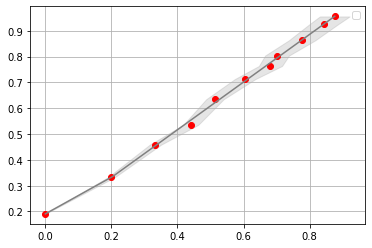

In [9]:
x = nominal_values(largeNozzle.mu)
y = nominal_values(largeNozzle.p_vessel_dim)
dy = std_devs(largeNozzle.p_vessel_dim)
dx = std_devs(largeNozzle.mu)

my_pwlf   = pwlf.PiecewiseLinFit( x , y )  #inicia aquí la sequencia del piecewiselinealfit 
res       = my_pwlf.fit( 2 ) 

xfit = np.linspace(0,max(x),100)
yfit = my_pwlf.predict(xfit)

plt.plot(x, y, 'or')
plt.plot(xfit, yfit, '-', color='gray')
plt.fill_betweenx(y, x - dx, x + dx,color='gray', alpha=0.2)
plt.legend()
plt.grid()

No handles with labels found to put in legend.


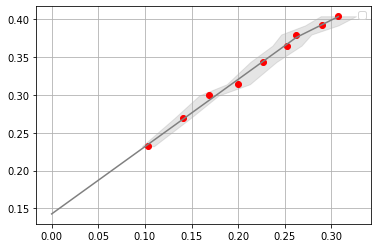

In [10]:
x = nominal_values(smallNozzle.mu)
y = nominal_values(smallNozzle.p_vessel_dim)
dy = std_devs(smallNozzle.p_vessel_dim)
dx = std_devs(smallNozzle.mu)

my_pwlf   = pwlf.PiecewiseLinFit( x , y )  #inicia aquí la sequencia del piecewiselinealfit 
res       = my_pwlf.fit( 2 ) 

xfit = np.linspace(0,max(x),100)
yfit = my_pwlf.predict(xfit)

plt.plot(x, y, 'or')
plt.plot(xfit, yfit, '-', color='gray')
plt.fill_betweenx(y, x - dx, x + dx,color='gray', alpha=0.2)
plt.legend()
plt.grid()

No handles with labels found to put in legend.


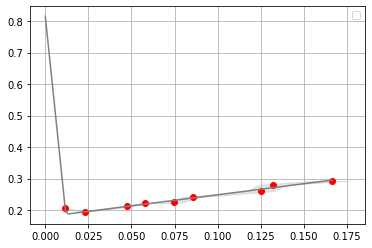

In [11]:
x = nominal_values(smallNozzle1.mu)
y = nominal_values(smallNozzle1.p_vessel_dim)
dy = std_devs(smallNozzle1.p_vessel_dim)
dx = std_devs(smallNozzle1.mu)

my_pwlf   = pwlf.PiecewiseLinFit( x , y )  #inicia aquí la sequencia del piecewiselinealfit 
res       = my_pwlf.fit( 2 ) 

xfit = np.linspace(0,max(x),100)
yfit = my_pwlf.predict(xfit)

plt.plot(x, y, 'or')
plt.plot(xfit, yfit, '-', color='gray')
plt.fill_betweenx(y, x - dx, x + dx,color='gray', alpha=0.2)
plt.legend()
plt.grid()

No handles with labels found to put in legend.


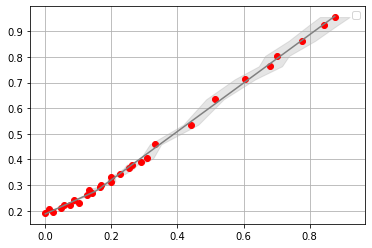

In [12]:
x = nominal_values(PvsMu.mu)
y = nominal_values(PvsMu.p_vessel_dim)
dy = std_devs(PvsMu.p_vessel_dim)
dx = std_devs(PvsMu.mu)

my_pwlf   = pwlf.PiecewiseLinFit( x , y )  #inicia alargeNozzlequí la sequencia del piecewiselinealfit 
res       = my_pwlf.fit( 2 ) 

xfit = np.linspace(0,max(x),100)
yfit = my_pwlf.predict(xfit)

plt.plot(x, y, 'or')
plt.plot(xfit, yfit, '-', color='gray')
plt.fill_betweenx(y, x - dx, x + dx,color='gray', alpha=0.2)
plt.legend()
plt.grid()

In [13]:
x1         = pd.read_csv ( 'x1.csv' , sep = ';' )



No handles with labels found to put in legend.


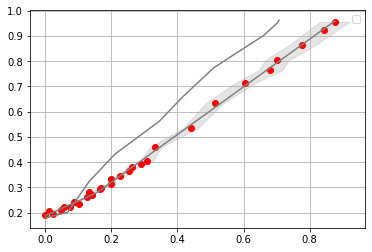

In [14]:
plt.plot(x, y, 'or')
plt.plot(x1.x,x1.y, '-', color='gray')
plt.plot(xfit, yfit, '-', color='gray')
plt.fill_betweenx(y, x - dx, x + dx,color='gray', alpha=0.2)
plt.legend()
plt.grid()